In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-44c8a7c9-796d-644a-eeb5-fd087c8faf27)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install split-folders

In [ ]:
import os
import cv2
import imghdr
import random
import matplotlib.image as mpimg
import splitfolders

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
def check_dir(dir_path):
  for directory_path, directory_names, filenames in os.walk(dir_path):
    print(f"There are {len(directory_names)} directories and {len(filenames)} images in '{directory_path}'.")

In [ ]:
#Credits: https://stackoverflow.com/questions/65438156/tensorflow-keras-error-unknown-image-file-format-one-of-jpeg-png-gif-bmp-re
#check for corrupted images
def check_images(source_dir, ext_list):
    bad_images=[]
    sub_list= os.listdir(source_dir)
    for class_name in sub_list:
        class_path=os.path.join(source_dir, class_name)
        print("Processing class directory ", class_name)
        if os.path.isdir(class_path):
            file_list=os.listdir(class_path)
            for file in file_list:               
                file_path=os.path.join(class_path,file)
                tip = imghdr.what(file_path) #check what file type is it
                if ext_list.count(tip) == 0: #if is not included in the recognised file types
                  bad_images.append(file_path) #is a bad image
                if os.path.isfile(file_path):
                    try:
                        img=cv2.imread(file_path) #if cv2 cannot get the shape of the image file then the file is corrupted
                        shape=img.shape 
                    except:
                        print('file ', file_path, ' is not a valid image file')
                        bad_images.append(file_path)
                else:
                    print(f"Error: Subdirectory {file} in '{class_path}'")
        else:
            print(f"Warning: There are files in {source_dir}, only sub directories should be contained")
    return bad_images

In [ ]:
source_dir =r'/content/drive/MyDrive/GL_Datasets'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print(bad_file_list[i])
else:
    print('no improper image files were found')

processing class directory  Recyclables
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Paper_140.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Paper_0.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Paper_112.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Paper_151.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Paper_1.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Plastic_4.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Plastic_2.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Plastic_1.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Plastic_3.jpg  is not a valid image file
file  /content/drive/MyDrive/GL_Datasets/Recyclables/Plastic_0.jpg  is not a valid image file
file  /content/drive/MyD

In [ ]:
bad_file_list = list(set(bad_file_list))
for i in range(len(bad_file_list)):
  os.remove(bad_file_list[i])

In [ ]:
check_dir("/content/drive/MyDrive/GL_Datasets") #check if dataset is extremely imbalanced

There are 3 directories and 0 images in '/content/drive/MyDrive/GL_Datasets'.
There are 0 directories and 14193 images in '/content/drive/MyDrive/GL_Datasets/Recyclables'.
There are 0 directories and 11561 images in '/content/drive/MyDrive/GL_Datasets/Landfill'.
There are 0 directories and 13708 images in '/content/drive/MyDrive/GL_Datasets/Compostable'.


In [ ]:
!rm -rf /content/train

In [ ]:
#80% training, 10% validation and 10% test
splitfolders.ratio('/content/drive/MyDrive/GL_Datasets', output="/content", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 39462 files [10:48, 60.88 files/s] 


In [ ]:
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

In [ ]:
check_dir(train_dir)
check_dir(val_dir)
check_dir(test_dir)

There are 3 directories and 0 images in '/content/train'.
There are 0 directories and 9248 images in '/content/train/Landfill'.
There are 0 directories and 10966 images in '/content/train/Compostable'.
There are 0 directories and 11354 images in '/content/train/Recyclables'.
There are 3 directories and 0 images in '/content/val'.
There are 0 directories and 1156 images in '/content/val/Landfill'.
There are 0 directories and 1370 images in '/content/val/Compostable'.
There are 0 directories and 1419 images in '/content/val/Recyclables'.
There are 3 directories and 0 images in '/content/test'.
There are 0 directories and 1157 images in '/content/test/Landfill'.
There are 0 directories and 1372 images in '/content/test/Compostable'.
There are 0 directories and 1420 images in '/content/test/Recyclables'.


In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 4

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = "categorical",
                                                                    batch_size = BATCH_SIZE, 
                                                                    shuffle = True,
                                                                    image_size = IMG_SIZE)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  label_mode = "categorical",
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = False, 
                                                                  image_size = IMG_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   label_mode ="categorical",
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = False, #do not shuffle otherwise if test_dataset is loaded, the order of the images will change
                                                                   image_size = IMG_SIZE)

Found 31568 files belonging to 3 classes.
Found 3945 files belonging to 3 classes.
Found 3949 files belonging to 3 classes.


In [ ]:
CLASS_NAMES = val_dataset.class_names
CLASS_NAMES

['Compostable', 'Landfill', 'Recyclables']

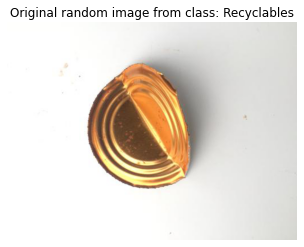

In [ ]:
#image is not resized to shape (224,224) as we are not getting the image from train_dataset
target_class = random.choice(CLASS_NAMES) 
target_train_dir = "/content/train/" + target_class 
random_train_img = random.choice(os.listdir(target_train_dir)) 
random_img_path = target_train_dir + "/" + random_train_img 
img = mpimg.imread(random_img_path) 
plt.imshow(img) 
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); 

In [ ]:
def preprocessing_img(img, label):
  return tf.cast(img, tf.float32), label #dtype float32 is computionally faster than dtype uint8

In [ ]:
train_dataset = train_dataset.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Feature extraction (no need to data augment as EfficientNet has a scaling layer built in the model)
INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #remove fully connected layers
base_model.trainable = False # freeze the layers to perform feature extraction

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer") 
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(CLASS_NAMES))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
 softmax_float32 (Activation  (None, 3)                0         
 )                                                               
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainab

In [ ]:
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
mixed_precision.global_policy() #to make the model train faster 

<Policy "mixed_float16">

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
LR = 0.0001 

In [ ]:
model.compile(loss="categorical_crossentropy", #labels are one-hot encoded
              optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=4,
                    steps_per_epoch=len(train_dataset),
                    validation_data=val_dataset,
                    validation_steps=len(val_dataset),
                    )

Epoch 1/4
7892/7892 [==============================] - 443s 54ms/step - loss: 0.3257 - accuracy: 0.8794 - val_loss: 0.2217 - val_accuracy: 0.9151
Epoch 2/4
7892/7892 [==============================] - 397s 50ms/step - loss: 0.1965 - accuracy: 0.9283 - val_loss: 0.1881 - val_accuracy: 0.9293
Epoch 3/4
7892/7892 [==============================] - 398s 50ms/step - loss: 0.1698 - accuracy: 0.9391 - val_loss: 0.1726 - val_accuracy: 0.9349
Epoch 4/4
7892/7892 [==============================] - 397s 50ms/step - loss: 0.1548 - accuracy: 0.9453 - val_loss: 0.1629 - val_accuracy: 0.9399


In [ ]:
def plot_accuracy_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

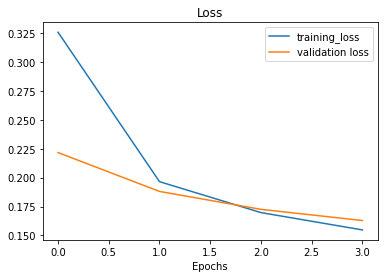

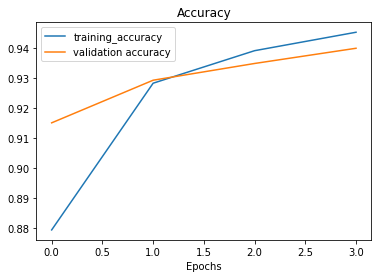

In [ ]:
plot_accuracy_loss_curves(history)

In [ ]:
test_results = model.evaluate(test_dataset)
test_results

988/988 [==============================] - 49s 50ms/step - loss: 0.1566 - accuracy: 0.9443


[0.156622514128685, 0.9442896842956543]

In [ ]:
def convert_and_predict_image(images, img_shape=224):

  img = tf.io.read_file(images)
  img = tf.io.decode_image(img) #convert to tensor
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.cast(img, tf.float32)

  return img

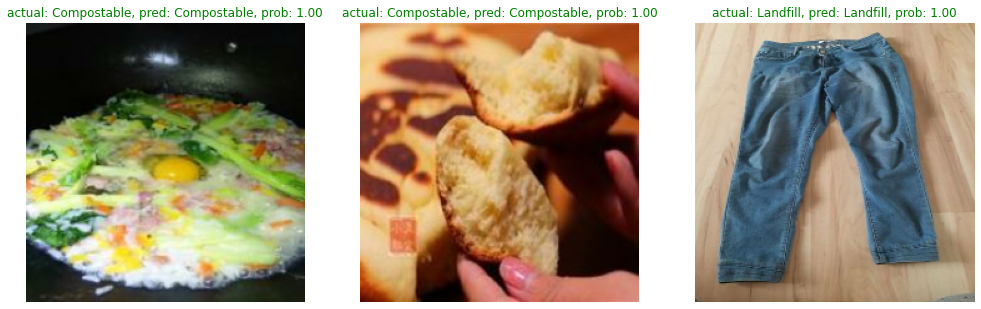

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(3):
 
  class_name = random.choice(CLASS_NAMES)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = convert_and_predict_image(filepath) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) #create a dimension 0 which is the batch size
  pred_class = CLASS_NAMES[pred_prob.argmax()] 

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c="g" if class_name == pred_class else "r", fontsize = 12)
  plt.axis(False);

In [ ]:
model.save("/content/GL_classification_model")

INFO:tensorflow:Assets written to: /content/GL_classification_model/assets


In [ ]:
!zip -r /content/GL_classification_model.zip /content/GL_classification_model

  adding: content/GL_classification_model/ (stored 0%)
  adding: content/GL_classification_model/saved_model.pb (deflated 91%)
  adding: content/GL_classification_model/assets/ (stored 0%)
  adding: content/GL_classification_model/variables/ (stored 0%)
  adding: content/GL_classification_model/variables/variables.index (deflated 73%)
  adding: content/GL_classification_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/GL_classification_model/keras_metadata.pb (deflated 96%)


In [ ]:
from google.colab import files
files.download("/content/GL_classification_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred_probs = model.predict(test_dataset, verbose=1)

988/988 [==============================] - 46s 44ms/step


In [ ]:
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[:5] 

array([0, 0, 2, 2, 1])

In [ ]:
y_labels = []
for _, labels in test_dataset.unbatch(): 
  y_labels.append(labels.numpy().argmax()) # append index that has the value of 1  (labels are one-hot)
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Inspired by https://github.com/mrdbourke/tensorflow-deep-learning
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  num_classes = cm.shape[0] # find the number of classes we're dealing with

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Reds) # the darker the color the more correct the class is
  fig.colorbar(cax)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(num_classes),
         yticks=np.arange(num_classes), 
         xticklabels=classes if classes else np.arange(cm.shape[0]), # axes will labeled with class names (if they exist) or ints
         yticklabels=classes if classes else np.arange(cm.shape[0]))

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

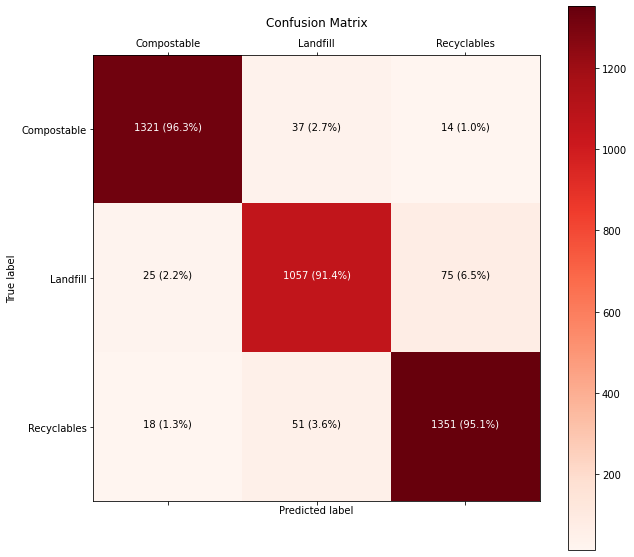

In [ ]:
plot_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=CLASS_NAMES,
                      figsize=(10, 10),
                      text_size=10,
                      norm=True,
                      savefig=False)

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'f1-score': 0.9656432748538013,
  'precision': 0.968475073313783,
  'recall': 0.9628279883381924,
  'support': 1372},
 '1': {'f1-score': 0.9183318853171155,
  'precision': 0.9231441048034934,
  'recall': 0.9135695764909249,
  'support': 1157},
 '2': {'f1-score': 0.9447552447552447,
  'precision': 0.9381944444444444,
  'recall': 0.9514084507042253,
  'support': 1420},
 'accuracy': 0.9442896935933147,
 'macro avg': {'f1-score': 0.9429101349753872,
  'precision': 0.9432712075205737,
  'recall': 0.9426020051777808,
  'support': 3949},
 'weighted avg': {'f1-score': 0.9442707044729719,
  'precision': 0.9443053028501552,
  'recall': 0.9442896935933147,
  'support': 3949}}

In [ ]:
f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    f1_scores[CLASS_NAMES[int(k)]] = v["f1-score"]
    
f1_scores

{'Compostable': 0.9656432748538013,
 'Landfill': 0.9183318853171155,
 'Recyclables': 0.9447552447552447}

In [ ]:
f1_scores_df = pd.DataFrame({"class_name": list(f1_scores.keys()),
                             "f1-score": list(f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores_df

,class_name,f1-score
0,Compostable,0.965643
2,Recyclables,0.944755
1,Landfill,0.918332


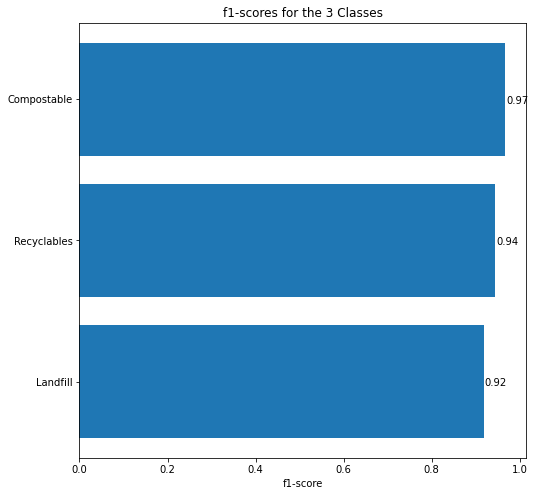

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
scores = ax.barh(range(len(f1_scores_df)), f1_scores_df["f1-score"].values)
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(list(f1_scores_df["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for the 3 Classes")
ax.invert_yaxis(); #Instead of having "Compostable" as the first yticklabel, we will have "Landfill" to be instead

for rect in scores:
  width = rect.get_width()
  ax.text(1.03*width, rect.get_y() + rect.get_height()/1.8,
          f"{width:.2f}",
          ha='center', va='bottom')